### **Авторы:**  Анастасия Ляппиева, Мария Балакаева, Сергей Шемякин 

#### **Часть 1**

Предположим модель CEV (Constant Elasticity of Variance): 

$$dS_t = (r-q)S_tdt + \sigma S_t^{\gamma}dW_t.$$

Модель рассматривается в риск-нейтральной мере.

Необходимо реализовать программу, которая на вход принимает следующие параметры $(S_0, r, q, \sigma, N, n, m, T)$, где $T$ - время до экспирации, $N$ - количество симуляций, $n$ - количество выплат, $m$ - шаг сетки и оценивает с использованием метода Монте-Карло цену опциона для контракта с дисконтированным платежом:

$$\sum_{i=1}^n e^{-r t_i} (S_{t_i} - S_{t_{i-1}})^{+},$$

где $t_i = iT/n$.

Необходимо выбрать параметры и сгенерировать таблицу цен опциона для различных пар $(N, m)$.


### *Решение*

Воспользуемся методом Эйлера-Маруямы, для аппроксимации СДУ на малых временных интервалах. 

Детерминированная часть СДУ:

$$(r-q)S_tdt \rightarrow (r-q)S_{t-1}\frac{T}{m}.$$

Стохастическая часть СДУ:

$$\sigma S_t^{\gamma}dW_t \rightarrow \sigma S_{t-1}^{\gamma}\sqrt{\frac{T}{m}} Z.$$ 

Чтобы избежать отрицательных значений цены акции (что невозможно в реальности), воспользуемся логнормальным приближением. Для этого перепишем СДУ в терминах логарифма цены $ln(S_t)$:

$$d\ln(S_t) = \left( 0 + (r - q) S_t \cdot \frac{1}{S_t} + \frac{1}{2} \sigma^2 S_t^{2\gamma} \cdot \left( -\frac{1}{S_t^2} \right) \right) dt + \sigma S_t^\gamma \cdot \frac{1}{S_t} dW_t,$$

$$d\ln(S_t) = \left( (r - q) - \frac{1}{2} \sigma^2 S_t^{2(\gamma - 1)} \right) dt + \sigma S_t^{\gamma - 1} dW_t.$$

 Дискретное приближение для $ln(S_t)$:

$$\ln(S_t) = \ln(S_{t-1}) + \left( r - q - \frac{1}{2} \sigma^2 S_{t-1}^{2(\gamma - 1)} \right) dt + \sigma S_{t-1}^{\gamma - 1} \sqrt{dt} \cdot Z,$$

 где $dt = T/m.$

 Возьмем экспоненту от обеих частей:

 $$S_t = S_{t-1} \cdot \exp\left( \left( r - q - \frac{1}{2} \sigma^2 S_{t-1}^{2(\gamma - 1)} \right) dt + \sigma S_{t-1}^{\gamma - 1} \sqrt{dt} \cdot Z \right).$$

In [1]:
import numpy as np
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt


In [2]:

def cev_model(S0, r, q, sigma, gamma, T, m, N):
    
    dt = T / m
    St = np.zeros((N, m + 1))
    St[:, 0] = S0
    for t in range(1, m + 1):

        Z = np.random.normal(0, 1, N)
        St[:, t] = St[:, t - 1] * np.exp((r - q - 0.5 * sigma**2 * St[:, t - 1]**(2 * (gamma - 1))) * dt +
                                         sigma * St[:, t - 1]**(gamma - 1) * np.sqrt(dt) * Z)
   
    return St

def option_price(S0, r, q, sigma, gamma, T, n, m, N):

    St = cev_model(S0, r, q, sigma, gamma, T, m, N)
    ti = np.linspace(0, T, n + 1)
    t_indices = (m * ti / T).astype(int)
    S_selected = St[:, t_indices]
    payoffs = np.maximum(S_selected[:, 1:] - S_selected[:, :-1], 0)
    discounted_payoffs = np.exp(-r * ti[1:]) * payoffs
    total_payoff = np.sum(discounted_payoffs, axis=1)
    option_price = np.mean(total_payoff)

    return option_price

S0 = 100
r = 0.05
q = 0.02
sigma = 0.2
gamma = 0.8
T = 1
n = 10

num_sim = np.arange(100, 10000, 100)
num_step = [10, 50, 100] # Количество шагов дискретизации

results = np.zeros((len(num_step), len(num_sim)))

for i, N in enumerate(num_step):
    for j, m in enumerate(num_sim):
        results[i, j] = option_price(S0, r, q, sigma, gamma, T, n, m, N)



In [3]:
table = pd.DataFrame(results)
table.columns = num_sim
table.index = num_step
table

,100,200,300,400,500,600,700,800,900,1000,...,9000,9100,9200,9300,9400,9500,9600,9700,9800,9900
10,11.447186,10.708461,10.237308,13.247870,10.133033,10.510527,9.246805,12.461823,11.164476,11.721156,...,11.818861,11.278826,13.772568,9.106345,11.089507,10.776414,9.497636,13.202978,11.903421,11.325598
50,12.401625,11.434308,12.209776,12.348157,13.361639,11.335501,10.925889,12.055109,11.454582,11.641950,...,12.249046,11.121300,11.357582,11.855944,11.592319,11.064038,10.347665,11.859289,10.196334,11.185468
100,11.469778,12.081442,11.822476,12.006887,11.586990,10.818731,11.751438,12.316213,11.832480,11.204781,...,11.613042,11.371868,12.192556,11.268793,11.316058,10.795466,12.081820,11.081516,10.605654,11.845005


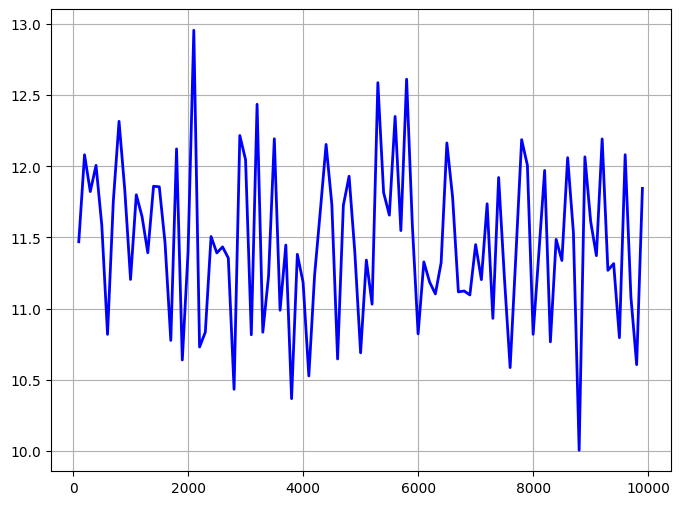

In [4]:
plt.figure(figsize=(8, 6))
plt.plot(num_sim, results[2,:], color='blue', linewidth=2)
plt.grid(True)
plt.show()

### **Часть 2**

Рассмотрим модель Мертона с прыжками в риск-нейтральной мере:

$$dS_t = rS_{t-}dt + \sigma S_{t-}dW_t + S_{t-}dJ_t,$$

$$J_t = \sum_{j = 1}^{N_t}(Y_j-1)$$

где $W$ - стандартное броуновское движение, $r$ и $\sigma$ - постоянные параметры, $Y_1$, $Y_2$, $\cdots$ н.о.р.с.в и $N_t$ - пуассоновский процесс с параметром интенсивности $\lambda$.

$Y_i$ принимают два значения $y_{-} < y_{+}$ с вероятностями $p$ и $1 - p.$

Необходимо реализовать программу которая получает на вход следующие параметры $(S_0, r, \sigma, y_{-}, y_{+}, p, \lambda, N, n, T, K)$, где $T$ - дата экпирации, $N$ - число симуляций, $n$ - количество дат наблюдения и реализует оценку азиатского опциона с фиксированным страйком $K$:

$$\left( K - \frac{1}{n}\sum_{i=1}^nS_{t_i}\right)^{+}$$

где $t_i = iT/n.$

Необходимо выбрать параметры и сгенерировать таблицу цен опциона для различных пар $(N, m)$.

### *Решение*

Будем пользоваться рекурсивной формулой для цены, которая была дана на лекции:

$$S_{t_{i+1}} = S_{t_i}e^{(\mu - \sigma^2/2)(t_{i+1}-t_i)+\sigma(W_{t_{i+1}}-W_{t_{i}})}\prod_{j = N_{t_i}+1}^{N_{t_{i+1}}}Y_j.$$

Рассмотрим логарифм $X = \log(S)$:

$$X_{t_{i+1}} = X_{t_i} + (\mu - \sigma^2/2)(t_{i+1}-t_i)+\sigma(W_{t_{i+1}}-W_{t_{i}}) + \sum_{j = N_{t_i}+1}^{N_{t_{i+1}}}\log(Y_j).$$

Будем использовать следующий алгоритм:

* симулируем $Z \sim N(0,1)$
* симулируем $N \sim Pois(\lambda(t_{i+1}-t_i))$. Если $N = 0$, то $M = 0$ и пропускаем следующий шаг
* симулируем $\log{Y_1}, \cdots, \log{Y_N}$ с биномиальным распределением и $M = \log{Y_1} + \cdots + \log{Y_N}$
* $X_{t_{i+1}} = X_{t_i} + (\mu - \sigma^2/2)(t_{i+1}-t_i) + \sigma \sqrt{(t_{i+1}-t_i)} Z + M$

In [5]:

def merton_jump_model(S0, r, sigma, y_minus, y_plus, p, lambd, T, m, N):

    dt = T / m
    X = np.zeros((N, m + 1))
    X[:, 0] = np.log(S0) 
    for t in range(1, m + 1):
        Z = np.random.normal(0, 1, N)
        N_jumps = np.random.poisson(lambd * dt, N)
        M = np.zeros(N)
        for i in range(N):
            if N_jumps[i] > 0:

                log_Y = np.log(np.where(np.random.rand(N_jumps[i]) < p, y_minus, y_plus))
                M[i] = np.sum(log_Y)
  
        X[:, t] = X[:, t - 1] + (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z + M
    St = np.exp(X)
    return St

def asian_put_option_price(S0, r, sigma, y_minus, y_plus, p, lambd, T, m, N, K):

    St = merton_jump_model(S0, r, sigma, y_minus, y_plus, p, lambd, T, m, N) 
    average_price = np.mean(St[:, 1:], axis=1) 
    payoff = np.exp(-r * T) * np.maximum(K - average_price, 0) 
    option_price = np.mean(payoff)
    return option_price

S0 = 100  
r = 0.05 
sigma = 0.2  
y_minus = 0.8  
y_plus = 1.2 
p = 0.5 
lambd = 0.5 
T = 1
K = 100  

num_sim = np.arange(100, 10000, 100)
num_step = [10, 50, 100]  # Количество шагов дискретизации

results = np.zeros((len(num_step), len(num_sim)))

for i, m in enumerate(num_step):
    for j, N in enumerate(num_sim):
        results[i, j] = asian_put_option_price(S0, r, sigma, y_minus, y_plus, p, lambd, T, m, N, K)

In [6]:
table = pd.DataFrame(results)
table.columns = num_sim
table.index = num_step
table

,100,200,300,400,500,600,700,800,900,1000,...,9000,9100,9200,9300,9400,9500,9600,9700,9800,9900
10,4.578284,5.017368,4.351117,3.952388,4.573983,4.588405,4.588998,4.540228,4.562962,5.051918,...,4.482087,4.494717,4.650930,4.520446,4.537790,4.650455,4.560332,4.359471,4.449686,4.542519
50,4.207967,3.935898,4.443821,4.077055,4.330336,4.170283,4.529817,4.171676,4.236207,4.139481,...,4.225260,4.244114,4.410103,4.251483,4.300900,4.288147,4.347469,4.416365,4.376206,4.317699
100,3.418805,4.793876,4.316437,4.543747,3.682470,3.924819,3.943987,4.295010,4.100988,4.482200,...,4.284351,4.242801,4.254985,4.298146,4.195574,4.249299,4.270899,4.198072,4.313338,4.364485


/var/folders/j7/ms50hmkx4sxgmqrwysp2jpgm0000gn/T/ipykernel_55471/2203079493.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


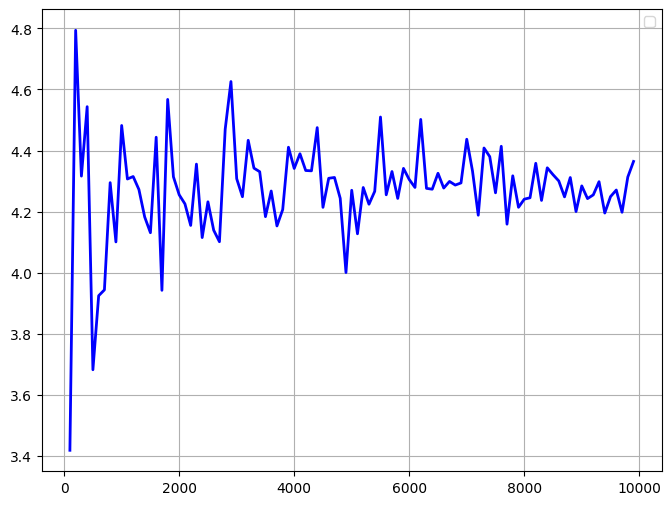

In [7]:

plt.figure(figsize=(8, 6))
plt.plot(num_sim, results[2,:], color='blue', linewidth=2)

plt.grid(True)
plt.legend()

plt.show()

### **Часть 3: Autocallable Barrier Reverse Convertible Pricing**

#### **Постановка задачи**

Рассмотрим два коррелированных актива, цена которых моделируется следующим образом:

$$
dS_t^1 = r S_t^1 dt + \sigma_1 S_t^1 dW_t^1,
$$
$$
dS_t^2 = r S_t^2 dt + \sigma_2 S_t^2 dW_t^2,
$$

где:
- $ S_t^1 $ и $ S_t^2 $ — цены двух активов в момент времени $ t $,
- $ r $ — безрисковая процентная ставка,
- $ \sigma_1 $ и $ \sigma_2 $ — волатильности активов,
- $ W_t^1 $ и $ W_t^2 $ — два стандартных броуновских движения с корреляцией $ \rho $.

Предположим, что начальные цены активов равны: $ S_0^1 = S_0^2 = 100 $.

#### **Описание контракта**

Рассмотрим **Autocallable Barrier Reverse Convertible** — структурированный продукт, который предполагает следующие выплаты:
1. **Купонные выплаты**: Владелец контракта получает купонные выплаты $ c $  в даты  <br>  $ 0 < t_1 < \ldots < t_n = T $.
2. **Выплата номинала**: Владелец получает номинальную выплату $ K = 100 $ в момент времени $ T $, если не произошло одного из двух событий:
   - **Раннее завершение**: Если на каком-либо из промежуточных временных шагов $ t_i $ выполняется условие $ S_{t_i}^1 \geq TB $ и $ S_{t_i}^2 \geq TB $ для некоторого $i<n$,  <br> где $ TB \geq S_0^1 = S_0^2 $, $TB = 100 $ — триггерный барьер. В этом случае контракт завершается досрочно, и владелец получает финальную выплату $ c + K $.
   - **Нарушение нижнего барьера**: Если на каком-либо из временных шагов $ t < T $ выполняется условие $ S_t^1 \leq B $ или $ S_t^2 \leq B $, где $B < S_0^1 = S_0^2$, $ B = 80 $ — нижний барьер, то купонные выплаты остаются неизменными, но финальная выплата (если контракт не был завершен досрочно) корректируется следующим образом:
     $$
     c + K - (K - \min(S_T^1, S_T^2))^+.
     $$

#### **Задание**

Предположим следующее: <br>
- $ S_0^1 = S_0^2 = K = TB = 100 $,
- $t_i = \frac{iT}{n}$
- $ t_i-t_{i-1} = 0.25 $. <br>


Необходимо реализовать программу, которая на вход принимает следующие параметры:

- $ r $ — безрисковая процентная ставка,
- $ \sigma_1 $ и $ \sigma_2 $ — волатильности активов,
- $ \rho $ — корреляция между броуновскими движениями,
- $ TB = 100 $ — триггерный барьер,
- $ B = 80 $ — нижний барьер,
- $ T $ — время до экспирации,
- $ n $ — количество купонных выплат,
- $ N $ — количество симуляций,
- $ m $ — количество шагов дискретизации.

Программа должна определить значение купона $ c $, при котором стоимость контракта $ V_0 = 100 $ в момент времени $ 0 $.

In [8]:
def correlated_brownian_motions(T, m, rho):
    dt = T / m
    Z1 = np.random.normal(0, np.sqrt(dt), size=m)
    Z2 = np.random.normal(0, np.sqrt(dt), size=m)
    W1 = np.cumsum(Z1)
    W2 = np.cumsum(rho * Z1 + np.sqrt(1 - rho**2) * Z2)
    return np.concatenate(([0], W1)), np.concatenate(([0], W2))

def calculate_contract_value(S0, r, sigma1, sigma2, rho, TB, B, T, n, N, m, c):
    dt = T / m
    payoffs = np.zeros(N)
    coupon_times = np.linspace(T / n, T, n) 
    
    for i in range(N):
        W1, W2 = correlated_brownian_motions(T, m, rho)
        S1 = S0 * np.exp((r - 0.5 * sigma1**2) * np.arange(m + 1) * dt + sigma1 * W1)
        S2 = S0 * np.exp((r - 0.5 * sigma2**2) * np.arange(m + 1) * dt + sigma2 * W2)
        
        early_termination = False
        termination_time = T
        
        for t_i in coupon_times:
            j = int(t_i / dt)  # Индекс ближайшего шага дискретизации
            if S1[j] >= TB and S2[j] >= TB:
                early_termination = True
                termination_time = t_i
                break
        
        lower_barrier_breach = np.any((S1 <= B) | (S2 <= B))
        
        if early_termination:
            paid_coupons = coupon_times[coupon_times <= termination_time]
            payoff = np.sum(c * np.exp(-r * paid_coupons)) + 100 * np.exp(-r * termination_time)
        elif lower_barrier_breach:
            payoff = np.sum(c * np.exp(-r * coupon_times)) + (100 - max(100 - min(S1[-1], S2[-1]), 0)) * np.exp(-r * T)
        else:
            payoff = np.sum(c * np.exp(-r * coupon_times)) + 100 * np.exp(-r * T)
        
        payoffs[i] = payoff
    
    return np.mean(payoffs)


def secant_method(S0, r, sigma1, sigma2, rho, TB, B, T, n, N, m, c0=0.0, c1=10.0, tolerance=1e-6, max_iter=100):
    for i in range(max_iter):
        # print(i)
        V0 = calculate_contract_value(S0, r, sigma1, sigma2, rho, TB, B, T, n, N, m, c0)
        V1 = calculate_contract_value(S0, r, sigma1, sigma2, rho, TB, B, T, n, N, m, c1)
        
        if abs(V1 - V0) < 1e-8:
            break
        
        c_new = c1 - (V1 - 100) * (c1 - c0) / (V1 - V0)
        
        if abs(c_new - c1) < tolerance:
            return c_new
        
        c0, c1 = c1, c_new
    
    return c1

In [9]:
S0 = 100
r = 0.05
sigma1 = 0.25
sigma2 = 0.25
rho = 0.5
TB = 100
B = 80
T = 1
n = 4
N = 10000
m = 100

c = secant_method(S0, r, sigma1, sigma2, rho, TB, B, T, n, N, m)
print(f"Coupon c: {c}")

Coupon c: 4.370300623057173


In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Загрузка карты России
map_df = gpd.read_file('russia.geojson')

# Загрузка данных по городам
data = {'City': ['Москва', 'Санкт-Петербург', 'Новосибирск'],
        'Production': [100, 80, 50]}
cities_df = gpd.GeoDataFrame(data)

# Визуализация
map_df.plot()
cities_df.plot(column='Production', legend=True)
plt.show()

ModuleNotFoundError: No module named 'geopandas'